### **Goal**

In this notebook we are going to train a neural network to infer the value of cosmological and astrophysical parameters from the Star-formation rate density (SFRD) of hydrodynamic simulations.

The SFRD is the global rate of formation of stars per unit of volume. It is a function of redshift:

SFRH = SFRH(z)

When changing cosmology and astrophysics, this quantity will be affected. It is possible to infer the value of the cosmological and astrophysical parameters just from measurements of this quantity:

$\vec{\theta}=f({\rm SFRH}(z))$        
 where
       
$\vec{\theta}=\{ \Omega_{\rm m}, \sigma_8, A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2} \}$

We are going to approximate the function $f$ with a neural network. In reality, we dont expect a one-to-one relation between the two variables, but more a distribution, i.e.

$p(\vec{\theta}|SFRD(z))$

in this notebook we are going to learn to calculate the mean and standard deviation of the above conditional probability distribution function using [moments networks](https://arxiv.org/abs/2011.05991).

Slides with the theory background aboute neural networks can be found [here](https://docs.google.com/presentation/d/15kvXYfaQk245MgctHqlGipUJdcpMxXxsbU7d3vF_ga4/edit?usp=sharing).

### **Background: the CAMELS simulations**
[https://www.camel-simulations.org]
- A collection of 10,000+ N-body + state-of-the-art (magneto-)hydrodynamic simulations
- Simulations vary 6 cosmological + astrophysical parameters, $\{ \Omega_{\rm m}, \sigma_8, A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2}\}$, plus initial random seed
- 2 suites: AREPO/IllustrisTNG + SIMBA/GIZMO
- Each suite contains 4 sets:
  - **LH**. Each sim has a different values of cosmological, astrophysical and random seed. Organized in a latin-hypercube. 1,000 sims.
  - **1P**: From a central/fiducial cosmology, simulations vary the value of one single parameter at a time. Same random seed for all sims. 61 sims.
  - **CV**: All simulations have the same cosmology and astrophysics, only different random seed. To explore cosmic variance. 27 sims.
  - **EX**: A set of 3 extreme models: 1) No feedback, 2) extreme AGN feedback and 3) extreme supernova feedback. 3 sims.

We are going to use data from the LH set. In particular the Star-formation rate density (SFRH).

## **Using the data**

The data we are going to use for this exercise is in [here](https://github.com/franciscovillaescusa/ML_lectures). To upload the data to the notebook do this:

- In a terminal from your computer do: git clone https://github.com/franciscovillaescusa/ML_lectures
- That will create a folder called ML_lectures. Inside that folder there is another folder called data that contains 4 files: SFRD_X.npy (with the star-formation rate densities) and params_X.txt (containing the value of the cosmological and astrophysical parameters of each simulation). X can be IllustrisTNG or SIMBA
- on the left bar of the google colab, click on the icon with the shape of a folder.
- click on the "upload to session storage" icon and upload the above files to google colab

### Downloading from the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Load libraries

In [2]:
import numpy as np
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

#### If GPUs are available, use them

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Let's work with our data

In [113]:
#INSERT YOUR DATA PATH HERE
sim_name = "SIMBA"
f_SFRD         = f'drive/MyDrive/nets/summer_school/SFRH_{sim_name}.npy'   #file with the SFRD data
f_params       = f'drive/MyDrive/nets/summer_school/params_{sim_name}.txt' #file with the value of the parameters
SFRD   = np.load(f_SFRD)      #read SFRD data
params = np.loadtxt(f_params)

### Lets set the value of the (hyper-)parameters

In [114]:
seed           = 42                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss = 1e7                       #set this to a large number. Used to compute
batch_size     = 32                       #number of elements each batch contains. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 1000                    #number of epochs to train the network. Hyper-parameter

f_model = 'best_model.pt'

### Lets write the function that loads the data.
For convenience, is good to use the pytorch data loader.
We need to define a python class and define the following two protocols:
- `__getitem__()`. Will return the input and output for one particular element of the dataset.
- `__len__()`. Will return the total number of elements in the dataset.italicized text.

It is important to normalize the data. There are two typical options:

- $\tilde{X}=(X-\bar{x})/\sigma_X$
- $\tilde{X}=[X-{\rm min}(X)]/[{\rm max}(X) - {\rm min}(X)]$

In [115]:
# This routine creates a dataset loader
# mode ---------> 'train', 'valid', 'test', 'all'. How to create the dataset
# f_SFRD -------> file containing the data for the SFRD
# f_params -----> file containing the value of the cosmological and astrophysical parameters
# batch_size ---> number of elements in the batch
# seed ---------> the data is randomly shuffled before being split into training, validation and testing. This set the random seed for that.
def create_dataset(mode, f_SFRD, f_params, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, f_SFRD, f_params, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)


# This class creates the dataset
class make_dataset():

    def __init__(self, mode, f_SFRD, f_params, seed):

        # read the data
        SFRD   = np.load(f_SFRD)      #read SFRD data
        params = np.loadtxt(f_params) #read value of the parameters

        # normalize the value of the SFRD
        SFRD[np.where(SFRD==0.0)] = 1e-12 #avoid points with SFRD=0
        SFRD = np.log10(SFRD)
        mean = np.mean(SFRD, axis=0, dtype=np.float64)
        std  = np.std(SFRD,  axis=0, dtype=np.float64)
        SFRD = (SFRD - mean)/std

        # Adding S8 instead of Sigma8
        omega = params[:, 0]
        sigma_8 = params[:, 1]
        s_8 = (sigma_8*(omega**(1/2))).reshape([1000, 1])

        params_new = np.hstack((params.copy(), s_8))
        permutation = [0, 6, 2, 3, 4, 5, 1]
        idx = np.empty_like(permutation)
        idx[permutation] = np.arange(len(permutation))
        params_new[:] = params_new[:, idx]
        params_s8 = np.delete(params_new, 6, 1)
        #SFRD = SFRD[params_s8[:,1] > 0.3]
        #params_s8 = params_s8[params_s8[:,1] > 0.3]

        #Normalising the value of parameters
        min_params = np.min(params_s8, axis=0)
        max_params = np.max(params_s8, axis=0)
        params_s8 = (params_s8 - min_params)/(max_params - min_params)

        # get the number of simulations and number of bins in the SFRD
        simulations = SFRD.shape[0]
        bins        = SFRD.shape[1]

        # get the size and offset depending on the type of dataset
        if mode=='train':
            size, offset = int(simulations*0.70), int(simulations*0.00)
        elif mode=='valid':
            size, offset = int(simulations*0.15), int(simulations*0.70)
        elif mode=='test':
            size, offset = int(simulations*0.15), int(simulations*0.85)
        elif mode=='all':
            size, offset = int(simulations*1.00), int(simulations*0.00)
        else:
          raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(params_s8.shape[0])
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding parameters and SFRH
        self.input  = torch.tensor(SFRD[indexes],   dtype=torch.float32)
        self.output = torch.tensor(params_s8[indexes], dtype=torch.float32)

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# get the data
train_loader = create_dataset('train', f_SFRD, f_params, batch_size, seed) #training data
valid_loader = create_dataset('valid', f_SFRD, f_params, batch_size, seed) #validation data

### Lets define the architecture of the neural network
Use a python class and define the layers in the `__init__()` protocol and the model in the `forward()` routine.

In [116]:
class DenseNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super().__init__()

        self.dense_block = nn.Sequential(
          nn.Linear(input_size,  hidden_size),
          nn.LeakyReLU(0.2),
          nn.Dropout(p=dropout_rate),
          nn.Linear(hidden_size,  output_size)
        )

    # forward pass
    def forward(self, x):
      return self.dense_block(x)

## Train!

### So we have flat frior. Let's try exp()

In [117]:
def new_prior(x:torch.Tensor) -> torch.Tensor:
  '''
  Func to perform conditional prior for weighted training.
  '''
  sigma = torch.tensor(0.5)
  s_mean = torch.tensor(0.8*(0.3**(1/2)))
  return torch.exp(-(torch.pow((x - s_mean),2)/(2*torch.pow(sigma,2))))

In [124]:
def training_and_validating_model(model,
                                  epochs,
                                  train_loader,
                                  valid_loader,
                                  optimizer,
                                  device,
                                  min_valid_loss,
                                  saving_name):
  start = time.time()
  train_value = np.zeros(epochs)
  valid_value = np.zeros(epochs)

  # do a loop over all epochs
  for epoch in range(epochs):

      # do training
      train_loss, points = 0.0, 0
      model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
      for SFRH_train, params_train in train_loader:  #do a loop over all elements in the training set
        # get the size of the batch

        #params_train = params_train[:,:6]
        bs = SFRH_train.shape[0]

        # move data to GPU
        params_train = params_train.to(device)
        SFRH_train   = SFRH_train.to(device)

        # compute the value predicted by the network
        pred = model(SFRH_train).to(device)

        # compute loss
        params_NN = pred[:,:6] #posterior mean
        errors_NN = pred[:,6:] #posterior std
        loss1 = torch.mean((params_NN - params_train)**2, axis=0)
        loss2 = torch.mean(((params_NN - params_train)**2 - errors_NN**2)**2, axis=0)
        loss  = torch.mean(new_prior(params_train)*(torch.log(loss1) + torch.log(loss2)))

        # compute cumulative loss and number of examples used
        train_loss += loss.item()*bs
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # get the average training loss
      train_loss /= points
      train_value[epoch] = train_loss


      # do validation
      valid_loss, points = 0.0, 0
      model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
      for SFRH_val, params_val in valid_loader: # do a loop over all elements in the validation set
          with torch.inference_mode():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.
            # get the size of the batch

            #params_val = params_val[:,:6]
            bs = SFRH_val.shape[0]

            # move data to the GPU
            params_val = params_val.to(device)
            SFRH_val   = SFRH_val.to(device)

            # compute prediction by the network
            pred = model(SFRH_val).to(device)

            params_NN = pred[:,:6]             #posterior mean
            errors_NN = pred[:,6:]             #posterior std
            loss1 = torch.mean((params_NN - params_val)**2, axis=0)
            loss2 = torch.mean(((params_NN - params_val)**2 - errors_NN**2)**2, axis=0)
            loss  = torch.mean(new_prior(params_val)*(torch.log(loss1) + torch.log(loss2)))

            # compute cumulative loss and number of examples used
            valid_loss += loss.item()*bs
            points     += bs


      # get the average validation loss
      valid_loss /= points
      valid_value[epoch] = valid_loss

      # save model if it has a lower validation loss
      if valid_loss<min_valid_loss:
          torch.save(model.state_dict(), saving_name)
          min_valid_loss = valid_loss

  stop = time.time()
  print(f"Model {saving_name} obtained loss {valid_loss:.3f}, time elapsed: {stop-start:.2f}s.")

  return train_value, valid_value, min_valid_loss

**Lets check all the possible combinations of these params:**
- lr : [1e-4, 2e-4, 3e-4, 4e-4, 5e-4]
- ridge reg(weight decay) : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
- hidden units : [50, 100, 150, 200, 250]
Const num of epochs : 1000 (reasoned empirically, one may check loss functions achieved)

In [119]:
lrs = [1e-4]#, 2e-4, 3e-4, 4e-4, 5e-4]
wds = [1e-1]#, 1e-2, 1e-3, 1e-4, 1e-5]
hidden_units = [150]#, 100, 150, 200, 250]
hyperparams_list = []
for lr in lrs:
  for wd in wds:
    for hidden_unit in hidden_units:
      hyperparams_list.append((lr, wd, hidden_unit))

## Let's train our models on grid of parameters from the previously achieved list

In [120]:
models_fam = {}
for hyperparams in hyperparams_list:
  lr = hyperparams[0]
  wd = hyperparams[1]
  hidden_units = hyperparams[2]
  model_name = f"model_lr{lr}_wd{wd}_hu{hidden_units}.pt"

  #Initialisation of model and defining optimizer
  model = DenseNet(100, hidden_units, 12, dr) #architecture (we output 12 parameters, 6 posterior means, and 6 posterior standard deviations)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

  #Establishing training algorithm
  temp = []
  train_loss, valid_loss, min_valid_loss = training_and_validating_model(model,
                                1000,
                                train_loader,
                                valid_loader,
                                optimizer,
                                device,
                                min_valid_loss,
                                model_name,
                                )
  temp.append((train_loss, valid_loss))
  models_fam[model_name] = temp

Model model_lr0.0001_wd0.1_hu150.pt obtained loss -9.254, time elapsed: 55.05s.


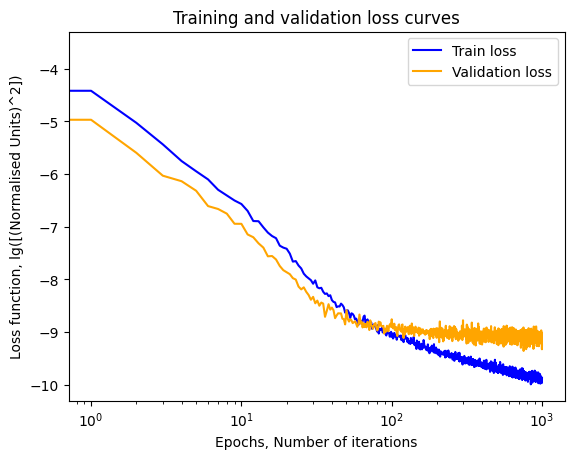

In [121]:
import matplotlib.pyplot as plt

plt.ylabel(r'$\mathcal{L}$')
plt.xlabel(r'${\rm epochs}$')

plt.plot(np.arange(epochs), models_fam["model_lr0.0001_wd0.1_hu150.pt"][0][0], c='b', label="Train loss")
plt.plot(np.arange(epochs), models_fam["model_lr0.0001_wd0.1_hu150.pt"][0][1], c='orange',  label="Validation loss")
plt.title("Training and validation loss curves")
plt.ylabel("Loss function, lg([(Normalised Units)^2])")
plt.xlabel("Epochs, Number of iterations")
plt.xscale('log')
plt.legend()
#plt.savefig("loss_func.png", dpi=300)

## Lets test the best-model!!

In [122]:
# get the test data
test_loader = create_dataset('test', f_SFRD, f_params, batch_size, seed) #test data

# load the best-model and move it to the GPU
#model = DenseNet(100, 50, 14, dr)
#model.load_state_dict(torch.load("model_lr0.0001_wd0.1_hu50.pt"))
model.to(device=device)

params_true = np.zeros((150,6), dtype=np.float32)
params_NN   = np.zeros((150,6), dtype=np.float32)
errors_NN   = np.zeros((150,6), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()
count = 0
for SFRH_test, params_test in test_loader:
    with torch.inference_mode():

      bs = SFRH_test.shape[0]

      # move data to GPU
      SFRH_test   = SFRH_test.to(device)
      #params_test = params_test[:,:6]
      params_test = params_test.to(device)

      # make prediction using network
      p = model(SFRH_test)

      params_true[count:count+bs,:] = params_test.cpu().numpy()
      params_NN[count:count+bs, :]  = p[:,:6].cpu().numpy()
      errors_NN[count:count+bs, :]  = p[:,6:].cpu().numpy()

      loss1 = torch.mean((p[:,:6] - params_test)**2, axis=0)
      loss2 = torch.mean(((p[:,:6] - params_test)**2 - p[:,6:])**2, axis=0)
      loss  = torch.mean(new_prior(params_test)*(torch.log(loss1) + torch.log(loss2)))

      # compute cumulative loss and number of examples used
      test_loss += loss.item()*bs
      points += SFRH_test.shape[0]

      count += bs

# get the average validation loss
test_loss /= points

print(f"Loss on test is {test_loss}")

Loss on test is -6.6582472674051925


## Visualising results

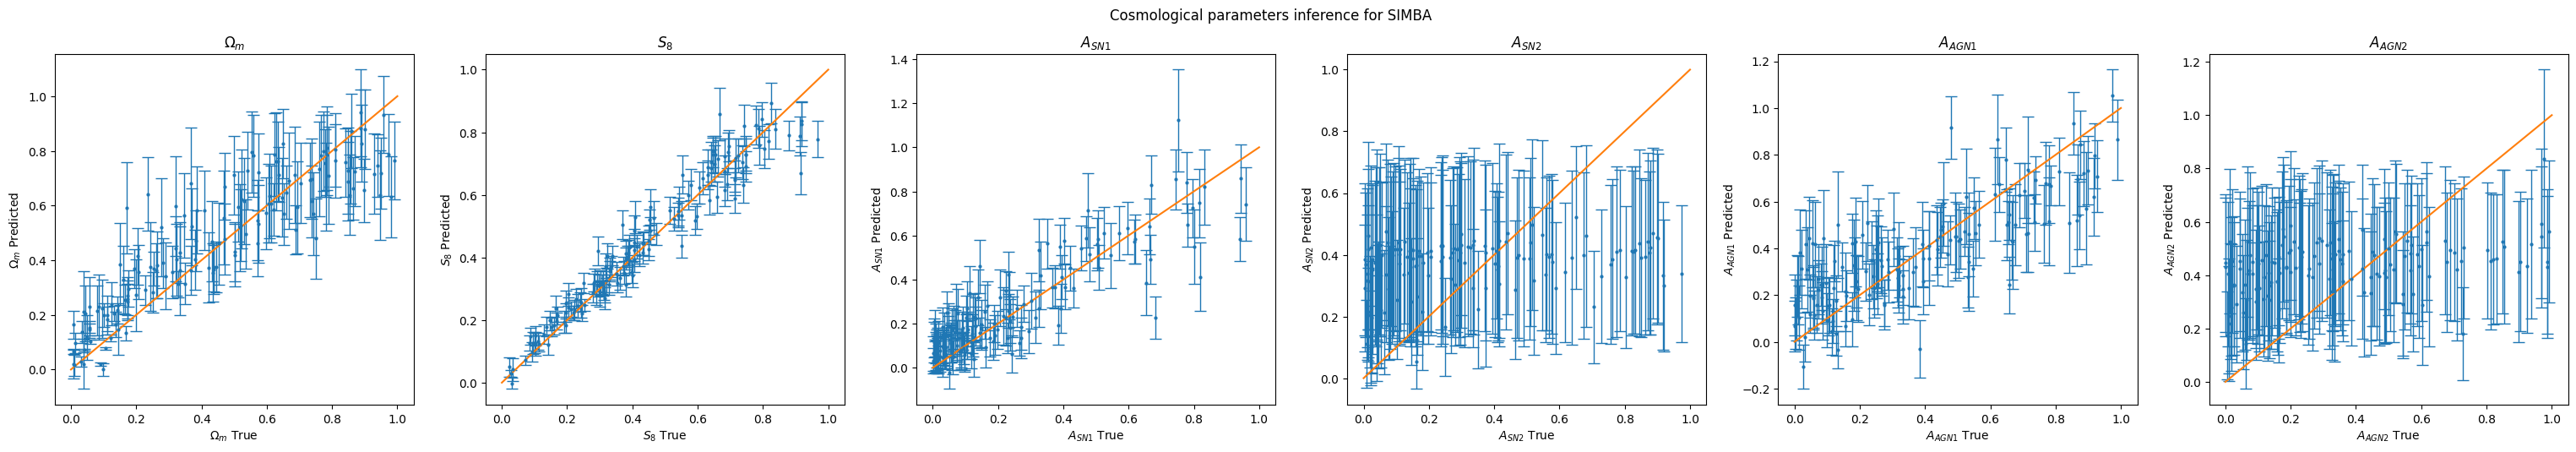

In [125]:
fig, axs = plt.subplots(1, 6)
fig.suptitle(f"Cosmological parameters inference for {sim_name}")
#fig = plt.figure()
fig.set_size_inches(38.4, 5.4)

params = [r'$\Omega_m$', r'$S_8$', r'$A_{SN1}$', r'$A_{SN2}$', r'$A_{AGN1}$', r'$A_{AGN2}$']
for i in range(6):
  axs[i].errorbar(params_true[:,i], params_NN[:,i], yerr=np.absolute(errors_NN[:,i]),
              lw=1, fmt='o',ms=2, elinewidth=1,capsize=5,linestyle='None')
  axs[i].plot([0,1],[0,1])
  axs[i].set_xlabel(f'{params[i]} True')
  axs[i].set_ylabel(f'{params[i]} Predicted')
  axs[i].set_title(params[i])

plt.savefig(f"params_{sim_name}.png", dpi=300)